# Import libraries

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import * 
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql.window import Window
from pyspark import StorageLevel
from sklearn.linear_model import LinearRegression
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import folium
from folium.plugins import MarkerCluster
import time

# Configuration of the session Spark

In [2]:
confi = SparkConf().setAppName("Assignment").set("spark.driver.memory", "8g").set("spark.executor.memory", "8g")
sp = SparkContext(conf=confi)
sql = SQLContext(sp)
session_spark = SparkSession(sp)

C:\Users\moi\Desktop\UTC\Cranfield\Module3_MLandBigData\spark-3.5.0-bin-hadoop3\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Data pre-processed

In [3]:
# Load the CSV file into a DataFrame
begin = time.time()
df = session_spark.read.option("header", "true").option("inferSchema", "true").csv("time_series_covid19_confirmed_global.csv")
df = df.fillna("Unknown", subset=["Province/State"])
df.select("Province/State","Country/Region","Lat","Long","1/22/20","1/23/20","1/24/20","1/25/20","1/26/20","1/27/20","1/28/20").show(10)

+--------------------+-------------------+--------+---------+-------+-------+-------+-------+-------+-------+-------+
|      Province/State|     Country/Region|     Lat|     Long|1/22/20|1/23/20|1/24/20|1/25/20|1/26/20|1/27/20|1/28/20|
+--------------------+-------------------+--------+---------+-------+-------+-------+-------+-------+-------+-------+
|             Unknown|        Afghanistan|33.93911|67.709953|      0|      0|      0|      0|      0|      0|      0|
|             Unknown|            Albania| 41.1533|  20.1683|      0|      0|      0|      0|      0|      0|      0|
|             Unknown|            Algeria| 28.0339|   1.6596|      0|      0|      0|      0|      0|      0|      0|
|             Unknown|            Andorra| 42.5063|   1.5218|      0|      0|      0|      0|      0|      0|      0|
|             Unknown|             Angola|-11.2027|  17.8739|      0|      0|      0|      0|      0|      0|      0|
|             Unknown|         Antarctica|-71.9499|   23

In [4]:
# Print the schema of the dataFrame
df.printSchema()

root
 |-- Province/State: string (nullable = false)
 |-- Country/Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- 1/22/20: integer (nullable = true)
 |-- 1/23/20: integer (nullable = true)
 |-- 1/24/20: integer (nullable = true)
 |-- 1/25/20: integer (nullable = true)
 |-- 1/26/20: integer (nullable = true)
 |-- 1/27/20: integer (nullable = true)
 |-- 1/28/20: integer (nullable = true)
 |-- 1/29/20: integer (nullable = true)
 |-- 1/30/20: integer (nullable = true)
 |-- 1/31/20: integer (nullable = true)
 |-- 2/1/20: integer (nullable = true)
 |-- 2/2/20: integer (nullable = true)
 |-- 2/3/20: integer (nullable = true)
 |-- 2/4/20: integer (nullable = true)
 |-- 2/5/20: integer (nullable = true)
 |-- 2/6/20: integer (nullable = true)
 |-- 2/7/20: integer (nullable = true)
 |-- 2/8/20: integer (nullable = true)
 |-- 2/9/20: integer (nullable = true)
 |-- 2/10/20: integer (nullable = true)
 |-- 2/11/20: integer (nullable = true)


In [5]:
# Display the number of rows
nb_rows = df.count()
print("Number of rows :", nb_rows)
# Display the number of columns
nb_cols = len(df.columns)
print("Number of columns :", nb_cols)

Number of rows : 289
Number of columns : 1147


In [6]:
def unpivot_dataframe(df):
    # Extracts date columns from the DataFrame
    date_columns = df.columns[4:]
    pivot_columns = [f"{col}" for col in date_columns]
    # Unpivots the DataFrame based on specified columns
    # The resulting DataFrame will have columns: Province/State, Country/Region, Lat, Long, Date, Cumulative_Positive_Cases
    return df.unpivot(["Province/State","Country/Region","Lat","Long"], pivot_columns, "Date", "Cumulative_Positive_Cases")

In [7]:
df = unpivot_dataframe(df)
# Converts the column Date to a DateType format using the to_date function
df = df.withColumn("Date", to_date(df["Date"], "M/d/yy"))
df.show(10)

+--------------+--------------+--------+---------+----------+-------------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Cumulative_Positive_Cases|
+--------------+--------------+--------+---------+----------+-------------------------+
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-22|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-23|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-24|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-25|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-26|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-27|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-28|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-29|                        0|
|       Unknown|   Afghanistan|3

## Data Cleaning

In [8]:
def column_na(df):
    col_na = []
    # Count the number of null values in each column
    for column in df.columns[1:]:
        nb_na = df.filter(col(column).isNull()).count()
        if nb_na > 0:
            col_na.append(column)
            print(f"Column '{column}': {nb_na} null values")

    # Display only column names with null values
    print("Columns with null values :", col_na)

column_na(df)

Column 'Lat': 2286 null values
Column 'Long': 2286 null values
Columns with null values : ['Lat', 'Long']


In [9]:
# Identifies rows where Lat or Long is null
rows_na = df.filter(isnull(col("Lat")) | isnull(col("Long")))
rows_na.select("Province/State","Country/Region","Lat","Long").distinct().show()

+--------------------+--------------+----+----+
|      Province/State|Country/Region| Lat|Long|
+--------------------+--------------+----+----+
|             Unknown|         China|NULL|NULL|
|Repatriated Trave...|        Canada|NULL|NULL|
+--------------------+--------------+----+----+



In [10]:
# Identifies rows where Lat or Long equals 0
rows_null = df.filter((col("Lat") == 0) | (col("Long") == 0))
rows_null.select("Province/State","Country/Region","Lat","Long").distinct().show()

+----------------+----------------+---+----+
|  Province/State|  Country/Region|Lat|Long|
+----------------+----------------+---+----+
|         Unknown|      MS Zaandam|0.0| 0.0|
|Diamond Princess|          Canada|0.0| 0.0|
|         Unknown|Diamond Princess|0.0| 0.0|
|  Grand Princess|          Canada|0.0| 0.0|
+----------------+----------------+---+----+



In [11]:
#Exclude rows where Lat or Long is null or equals 0
df = df.filter(col("Lat").isNotNull() & col("Long").isNotNull() & ((col("Lat") != 0) & (col("Long") != 0)))
rows_na = df.filter(isnull(col("Lat")) | isnull(col("Long"))|(col("Lat") == 0) | (col("Long") == 0))
rows_na.select("Province/State","Country/Region","Lat","Long").distinct().show()

+--------------+--------------+---+----+
|Province/State|Country/Region|Lat|Long|
+--------------+--------------+---+----+
+--------------+--------------+---+----+



In [12]:
#Converts the pyspark dataFrame to a pandas dataFrame and saves the pandas dataFrame to a CSV file
df.toPandas().to_csv("dataframe_1_s419255.csv", header = True, index = False)

In [13]:
df_final = session_spark.read.option("header", "true").option("inferSchema", "true").csv("dataframe_1_s419255.csv")
df_final.show(5)

+--------------+--------------+--------+---------+----------+-------------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Cumulative_Positive_Cases|
+--------------+--------------+--------+---------+----------+-------------------------+
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-22|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-23|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-24|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-25|                        0|
|       Unknown|   Afghanistan|33.93911|67.709953|2020-01-26|                        0|
+--------------+--------------+--------+---------+----------+-------------------------+
only showing top 5 rows



In [14]:
#Identifies rows where the cumulative positive cases are lower than the previous day's cumulative positive cases.
def cases_err(df):
    window_spec = Window.partitionBy("Country/Region", "Province/State").orderBy("Date")
    #Add the column of previous positive cumulative cases
    df = df.withColumn("Previous_Cumulative_Positive_Cases", lag(col("Cumulative_Positive_Cases"), 1, default=0).over(window_spec))
    # Find the rows where the cumulative positive cases are less than the previous ones
    df1 = df.filter(col("Cumulative_Positive_Cases") < col("Previous_Cumulative_Positive_Cases"))
    df = df.drop("Previous_Cumulative_Positive_Cases")
    return df1

In [15]:
df_errors = cases_err(df_final)
df_errors = df_errors.orderBy("Country/Region","Province/State","Date")
print("Number of errors with the column Cumulative_Positive_Cases:",df_errors.count())
df_errors.show(5)

Number of errors with the column Cumulative_Positive_Cases: 346
+--------------+-------------------+--------+---------+----------+-------------------------+----------------------------------+
|Province/State|     Country/Region|     Lat|     Long|      Date|Cumulative_Positive_Cases|Previous_Cumulative_Positive_Cases|
+--------------+-------------------+--------+---------+----------+-------------------------+----------------------------------+
|       Unknown|        Afghanistan|33.93911|67.709953|2020-03-20|                       24|                                26|
|       Unknown|        Afghanistan|33.93911|67.709953|2022-01-03|                   158183|                            158189|
|       Unknown|        Afghanistan|33.93911|67.709953|2023-02-04|                   208621|                            208669|
|       Unknown|Antigua and Barbuda| 17.0608| -61.7964|2020-07-03|                       68|                                69|
|       Unknown|Antigua and Barbuda| 17.

In [16]:
# Checks and corrects cumulative positive cases in a DataFrame.
def check_cases(df1):
    # Selects the relevant columns in the input dataFrame and transforms them into a list
    df_cases = df1.select("Cumulative_Positive_Cases")
    cases = [row["Cumulative_Positive_Cases"] for row in df_cases.collect()]
    df_country = df1.select("Country/Region")
    country = [row["Country/Region"] for row in df_country.collect()]
    df_province = df1.select("Province/State")
    province = [row["Province/State"] for row in df_province.collect()]
    df_date = df1.select("Date")
    date = [row["Date"] for row in df_date.collect()]
    # Iterates through the data to correct cumulative positive cases
    for i in range (1,len(cases)):
        if country[i] == country[i-1] and province[i] == province[i-1]:
            if cases[i] < cases [i-1]:
                cases[i] = cases[i-1]
    # Defines the schema for the new dataFrame
    schema = StructType([
        StructField("Province/State", StringType(), True),
        StructField("Country/Region", StringType(), True),
        StructField("Date", DateType(), True),
        StructField("Cumulative_Positive_Cases", IntegerType(), True)
    ])
    # Creates a new dataFrame with corrected cumulative positive cases
    df2 = session_spark.createDataFrame(zip(province,country,date,cases), schema=schema)
    # Drops the original column "Cumulative_Positive_Cases" from the input dataFrame
    df1 = df1.drop("Cumulative_Positive_Cases")
    # Joins the corrected dataFrame with the input dataFrame based on Province/State, Country/Region, and Date
    df1 = df1.join(df2.select("Province/State","Country/Region","Date","Cumulative_Positive_Cases"), on=["Province/State","Country/Region","Date"], how="left_outer")
    df1 = df1.orderBy("Country/Region","Province/State","Date")
    return df1

In [17]:
df_final = check_cases(df_final)

In [18]:
df_errors = cases_err(df_final)
df_errors = df_errors.orderBy("Country/Region","Province/State","Date")
print("Number of errors with the column Cumulative_Positive_Cases:",df_errors.count())
df_errors.show(5)

Number of errors with the column Cumulative_Positive_Cases: 0
+--------------+--------------+----+---+----+-------------------------+----------------------------------+
|Province/State|Country/Region|Date|Lat|Long|Cumulative_Positive_Cases|Previous_Cumulative_Positive_Cases|
+--------------+--------------+----+---+----+-------------------------+----------------------------------+
+--------------+--------------+----+---+----+-------------------------+----------------------------------+



In [19]:
df_final.toPandas().to_csv("dataframe_2_s419255.csv", header = True, index = False)

## Creation of columns for queries

In [20]:
df_final = session_spark.read.option("header", "true").option("inferSchema", "true").csv("dataframe_2_s419255.csv")
df_final.show(5)

+--------------+--------------+----------+--------+---------+-------------------------+
|Province/State|Country/Region|      Date|     Lat|     Long|Cumulative_Positive_Cases|
+--------------+--------------+----------+--------+---------+-------------------------+
|       Unknown|   Afghanistan|2020-01-22|33.93911|67.709953|                        0|
|       Unknown|   Afghanistan|2020-01-23|33.93911|67.709953|                        0|
|       Unknown|   Afghanistan|2020-01-24|33.93911|67.709953|                        0|
|       Unknown|   Afghanistan|2020-01-25|33.93911|67.709953|                        0|
|       Unknown|   Afghanistan|2020-01-26|33.93911|67.709953|                        0|
+--------------+--------------+----------+--------+---------+-------------------------+
only showing top 5 rows



In [21]:
#Assigns continent value to rows in a dataFrame based on Province/State or Country/Region
def continent(df):
    df = df.drop("Continent")
    # Define lists of countries or states belonging to different continents
    Africa_list = ['Algeria','Angola','Benin','Botswana','Burundi','Burkina Faso','Cabo Verde','Cameroon','Central African Republic','Chad','Comoros','Congo (Brazzaville)','Congo (Kinshasa)','Cote d\'Ivoire','Djibouti','Dominican Republic','Egypt','Equatorial Guinea','Eritrea','Ethiopia','Eswatini','Gabon','Gambia','Ghana','Guinea','Guinea-Bissau','Kenya','Lesotho','Liberia','Libya','Madagascar','Malawi','Mali','Mauritania','Mauritius','Morocco','Mozambique','Namibia','Niger','Nigeria','Rwanda','Sao Tome and Principe','Senegal','Seychelles','Sierra Leone','Somalia','South Africa','South Sudan','Sudan','Tanzania','Togo','Tunisia','Uganda','Zambia','Zimbabwe','Reunion','Mayotte','Saint Helena, Ascension and Tristan da Cunha']
    America_list = ['Antigua and Barbuda','Argentina','Bahamas','Barbados','Belize','Bolivia','Brazil','Canada','Chile','Colombia','Costa Rica','Cuba','Dominica','Ecuador','El Salvador','Grenada','Guatemala','Guyana','Haiti','Honduras','Jamaica','Mexico','Nicaragua','Panama','Paraguay','Peru','Saint Kitts and Nevis', 'Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago','US','Uruguay','Venezuela','Alberta','British Columbia','Manitoba','New Brunswick','Newfoundland and Labrador','Northwest Territories','Nova Scotia','Nunavut','Ontario','Quebec','Prince Edward Island','Yukon','Saskatchewan','Greenland','French Guiana','Guadeloupe','Martinique','Saint Barthelemy','Saint Pierre and Miquelon','St Martin','Aruba','Bonaire, Sint Eustatius and Saba','Curacao','Sint Maarten','Anguilla','Bermuda','British Virgin Islands','Cayman Islands','Falkland Islands (Malvinas)','Montserrat','Turks and Caicos Islands']
    Antarctica_list = ['Antarctica']
    Asia_list = ['Afghanistan','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei','Burma','Cambodia','China','India','Indonesia','Iran','Iraq','Israel','Japan','Jordan','Kazakhstan','Korea, North','Korea, South','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia','Maldives','Mongolia','Nepal','Oman','Pakistan','Philippines','Qatar','Saudi Arabia','Singapore','Sri Lanka','Syria','Taiwan*','Tajikistan','Thailand','Timor-Leste','United Arab Emirates','Uzbekistan','Vietnam','Yemen','West Bank and Gaza','Winter Olympics 2022','Summer Olympics 2020','Anhui','Beijing','Chongqing','Fujian','Gansu','Guangdong','Guangxi','Guizhou','Hainan','Hebei','Heilongjiang','Henan','Hong Kong','Hubei','Hunan','Inner Mongolia','Jiangsu','Jiangxi','Jilin','Liaoning','Macau','Ningxia','Qinghai','Shaanxi','Shandong','Shanghai','Shanxi','Sichuan','Tianjin','Tibet','Xinjiang','Yunnan','Zhejiang']
    Europe_list = ['Albania','Andorra','Armenia','Austria','Belgium','Belarus','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Georgia','Germany','Greece','Holy See','Hungary','Iceland','Ireland','Italy','Kosovo','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Moldova','Monaco','Montenegro','Netherlands','North Macedonia','Norway','Poland','Portugal','Romania','Russia','San Marino','Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland','Turkey','Ukraine','United Kingdom','Faroe Islands','Channel Islands','Gibraltar','Guernsey','Isle of Man','Jersey']
    Oceania_list = ['Australia','Fiji','Kiribati','Marshall Islands','Micronesia','Nauru','New Zealand','Palau','Papua New Guinea','Samoa','Solomon Islands','Tonga','Tuvalu','Vanuatu','Australian Capital Territory','New South Wales','Northern Territory','South Australia','Tasmania','Queensland','Victoria','Western Australia','French Polynesia','New Caledonia','Wallis and Futuna','Cook Islands','Niue','Pitcairn Islands']
    # Create a temporary column Place based on Province/State or Country/Region
    df = df.withColumn("Place",when(col("Province/State") != "Unknown", col("Province/State")).otherwise(col("Country/Region")))
    # Assign a continent value based on the column Place
    df = df.withColumn("Continent", when(df["Place"].isin(Africa_list), lit("Africa")).when(df["Place"].isin(America_list), lit("America"))
    .when(df["Place"].isin(Antarctica_list), lit("Antarctica")).when(df["Place"].isin(Asia_list), lit("Asia")).when(df["Place"].isin(Europe_list), lit("Europe"))
    .when(df["Place"].isin(Oceania_list), lit("Oceania")).otherwise(lit(None)))
    df = df.drop("Place")
    df = df.select("Continent", *df.columns[:-1])
    return df

In [22]:
df_final = continent(df_final)
#df_final.show(10)

In [23]:
def date(df):
    # Extraction of the columns Month, Day,Year and Week 
    df = df.withColumn("Month", month(df["Date"]))
    df = df.withColumn("Day", dayofmonth(df["Date"]))
    df = df.withColumn("Year", year(df["Date"]))
    #The column Year_Week helps identify the corresponding year for each week
    # For instance, 1/1/23 is recognized as the 52nd week of 2022 resulting in the Week value being 52
    #and the Year_Week value being 2022.
    df = df.withColumn("Year_Week", year(df["Date"]))
    df = df.withColumn("Week", weekofyear(df["Date"]))
    df = df.select("Continent","Province/State","Country/Region","Lat","Long","Day","Month","Year","Week","Year_Week","Cumulative_Positive_Cases")
    return df

In [24]:
df_final = date(df_final)
#df_final.show(5)

In [25]:
df_final.filter((col("Week") == 53) & (col("Year") == 2021)).show(8)

+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+
|Continent|Province/State|Country/Region|     Lat|     Long|Day|Month|Year|Week|Year_Week|Cumulative_Positive_Cases|
+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|  1|    1|2021|  53|     2021|                    52513|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|  2|    1|2021|  53|     2021|                    52586|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|  3|    1|2021|  53|     2021|                    52709|
|   Europe|       Unknown|       Albania| 41.1533|  20.1683|  1|    1|2021|  53|     2021|                    58316|
|   Europe|       Unknown|       Albania| 41.1533|  20.1683|  2|    1|2021|  53|     2021|                    58991|
|   Europe|       Unknown|       Albania| 41.1533|  20.1683|  3|

In [26]:
# Adjust the column Year_Week based on the defined condition
condition = ((col("Week") >= 52) & (col("Month") == 1))
df_final = df_final.withColumn("Year_Week",when(condition, col("Year_Week")-1).otherwise(col("Year_Week")))

In [27]:
df_final.filter((col("Week") == 53) & (col("Year") == 2021)).show(8)

+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+
|Continent|Province/State|Country/Region|     Lat|     Long|Day|Month|Year|Week|Year_Week|Cumulative_Positive_Cases|
+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|  1|    1|2021|  53|     2020|                    52513|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|  2|    1|2021|  53|     2020|                    52586|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|  3|    1|2021|  53|     2020|                    52709|
|   Europe|       Unknown|       Albania| 41.1533|  20.1683|  1|    1|2021|  53|     2020|                    58316|
|   Europe|       Unknown|       Albania| 41.1533|  20.1683|  2|    1|2021|  53|     2020|                    58991|
|   Europe|       Unknown|       Albania| 41.1533|  20.1683|  3|

In [28]:
# Create a new column in the input dataframe for the number of new positive cases per day 
def daily_case(df) : 
    window_spec = Window.partitionBy("Country/Region", "Province/State").orderBy("Year", "Month", "Day")
     # Use the function lag to get the value of the previous day's cumulative positive cases
    df = df.withColumn("Previous_Cumulative_Positive_Cases", lag(col("Cumulative_Positive_Cases"),1,default=0).over(window_spec))
    # Calculate the number of new positive cases for each day
    df = df.withColumn("Positive_Cases", col("Cumulative_Positive_Cases") - col("Previous_Cumulative_Positive_Cases"))
    df = df.drop("Previous_Cumulative_Positive_Cases")
    return df

In [29]:
df_final = daily_case(df_final)
time_preprocessed = time.time() - begin
print("Data Preprocessed - Processing time :",time_preprocessed)

Data Preprocessed - Processing time : 99.09732723236084


In [30]:
df_final.select("Continent","Province/State","Country/Region","Lat","Long","Day","Month","Year","Week","Positive_Cases","Cumulative_Positive_Cases").show(20)

+---------+--------------+--------------+--------+---------+---+-----+----+----+--------------+-------------------------+
|Continent|Province/State|Country/Region|     Lat|     Long|Day|Month|Year|Week|Positive_Cases|Cumulative_Positive_Cases|
+---------+--------------+--------------+--------+---------+---+-----+----+----+--------------+-------------------------+
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 22|    1|2020|   4|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 23|    1|2020|   4|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 24|    1|2020|   4|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 25|    1|2020|   4|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 26|    1|2020|   4|             0|                        0|
|     Asia|       Unknow

In [31]:
df_final = df_final.orderBy("Country/Region","Province/State","Year","Month","Day")
df_final.toPandas().to_csv("dataframe_3_s419255.csv", header = True, index = False)

# Query 1

In [32]:
df_final = session_spark.read.option("header", "true").option("inferSchema", "true").csv("dataframe_3_s419255.csv")
df_final.show(10)

+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+--------------+
|Continent|Province/State|Country/Region|     Lat|     Long|Day|Month|Year|Week|Year_Week|Cumulative_Positive_Cases|Positive_Cases|
+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+--------------+
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 22|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 23|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 24|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 25|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 26|    1|2020| 

In [33]:
df_final.printSchema()

root
 |-- Continent: string (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Year_Week: integer (nullable = true)
 |-- Cumulative_Positive_Cases: integer (nullable = true)
 |-- Positive_Cases: integer (nullable = true)



In [34]:
df_final.select("Continent","Province/State","Country/Region","Day","Month","Year","Week","Positive_Cases","Cumulative_Positive_Cases").filter((col("Country/Region") == "China") & (col("Year") == 2020)).show()

+---------+--------------+--------------+---+-----+----+----+--------------+-------------------------+
|Continent|Province/State|Country/Region|Day|Month|Year|Week|Positive_Cases|Cumulative_Positive_Cases|
+---------+--------------+--------------+---+-----+----+----+--------------+-------------------------+
|     Asia|         Anhui|         China| 22|    1|2020|   4|             1|                        1|
|     Asia|         Anhui|         China| 23|    1|2020|   4|             8|                        9|
|     Asia|         Anhui|         China| 24|    1|2020|   4|             6|                       15|
|     Asia|         Anhui|         China| 25|    1|2020|   4|            24|                       39|
|     Asia|         Anhui|         China| 26|    1|2020|   4|            21|                       60|
|     Asia|         Anhui|         China| 27|    1|2020|   5|            10|                       70|
|     Asia|         Anhui|         China| 28|    1|2020|   5|            

In [35]:
begin = time.time()

In [36]:
df_query1 = df_final.select("Province/State","Country/Region","Day","Month","Year","Positive_Cases")
# Calculate the total number of positives cases of COVID-19 per month by country
df_query1 = df_query1.groupBy("Country/Region", "Month","Year").agg(sum("Positive_Cases").alias("Total_Positive_Cases"),countDistinct("Day").alias("Nb_days"))
# Calculate the average number of confirmed cases per day for each month
df_query1 = df_query1.withColumn("Daily_Positive_Cases", round((col("Total_Positive_Cases") / col("Nb_days")),2))
df_query1 = df_query1.select("Country/Region","Month","Year","Daily_Positive_Cases")
df_query1 = df_query1.orderBy("Country/Region","Year","Month")
# Calculate the processing time for the query
time_query1 = time.time() - begin
print("Query1 - Processing time :",time_query1)

Query1 - Processing time : 0.14421916007995605


In [37]:
df_query1.show()

+--------------+-----+----+--------------------+
|Country/Region|Month|Year|Daily_Positive_Cases|
+--------------+-----+----+--------------------+
|   Afghanistan|    1|2020|                 0.0|
|   Afghanistan|    2|2020|                0.17|
|   Afghanistan|    3|2020|                5.19|
|   Afghanistan|    4|2020|               55.37|
|   Afghanistan|    5|2020|              430.74|
|   Afghanistan|    6|2020|              542.17|
|   Afghanistan|    7|2020|              167.19|
|   Afghanistan|    8|2020|               52.26|
|   Afghanistan|    9|2020|               36.87|
|   Afghanistan|   10|2020|               63.87|
|   Afghanistan|   11|2020|               162.7|
|   Afghanistan|   12|2020|              197.26|
|   Afghanistan|    1|2021|               86.87|
|   Afghanistan|    2|2021|               24.68|
|   Afghanistan|    3|2021|               23.87|
|   Afghanistan|    4|2021|               109.7|
|   Afghanistan|    5|2021|               390.1|
|   Afghanistan|    

In [38]:
df_query1.toPandas().to_csv("query1_s419255.csv", header = True, index = False)

# Plot - Query1

In [39]:
df_query1_plt = session_spark.read.option("header", "true").option("inferSchema", "true").csv("query1_s419255.csv")
df_query1_plt.show()

+--------------+-----+----+--------------------+
|Country/Region|Month|Year|Daily_Positive_Cases|
+--------------+-----+----+--------------------+
|   Afghanistan|    1|2020|                 0.0|
|   Afghanistan|    2|2020|                0.17|
|   Afghanistan|    3|2020|                5.19|
|   Afghanistan|    4|2020|               55.37|
|   Afghanistan|    5|2020|              430.74|
|   Afghanistan|    6|2020|              542.17|
|   Afghanistan|    7|2020|              167.19|
|   Afghanistan|    8|2020|               52.26|
|   Afghanistan|    9|2020|               36.87|
|   Afghanistan|   10|2020|               63.87|
|   Afghanistan|   11|2020|               162.7|
|   Afghanistan|   12|2020|              197.26|
|   Afghanistan|    1|2021|               86.87|
|   Afghanistan|    2|2021|               24.68|
|   Afghanistan|    3|2021|               23.87|
|   Afghanistan|    4|2021|               109.7|
|   Afghanistan|    5|2021|               390.1|
|   Afghanistan|    

In [40]:
df_query1_plt.printSchema()

root
 |-- Country/Region: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Daily_Positive_Cases: double (nullable = true)



In [41]:
# Create a histogram comparing daily positive cases by month and by country for specified years.
def query1_plot(df_query1_plt,countries,year,year1):
    # Validate input years
    valid_years = [2020, 2021, 2022, 2023] 
    if year not in valid_years:
        print("Wrong value for the year")
        return
    if year1 not in valid_years:
        print("Wrong value for the year")
        return
    # Filter the dataFrame for the specified years
    df_query1_plt = df_query1_plt.filter((col("Year") == year) | (col("Year") == year1))
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    # Collect distinct months and years
    month_year_df = df_query1_plt.select("Month", "Year").distinct().collect()
    month_year_df = sorted(month_year_df, key=lambda x: (x.Year, x.Month))
    month_year = [f"{row['Month']}/{row['Year']}" for row in month_year_df]
    # Set the width of the bars
    bar_width = 0.8
    for i, country in enumerate(countries):
        cases_country = df_query1_plt.filter(col("Country/Region") == country)
        # Collect daily cases
        daily_cases_df = cases_country.select("Daily_Positive_Cases").collect()
        daily_cases = [row["Daily_Positive_Cases"] for row in daily_cases_df]
        # Calculate the position of bars for each country
        bar_positions = [pos + i * bar_width for pos in range(len(month_year))]
        # Plot bars for each country
        plt.bar(bar_positions, daily_cases, bar_width, label=country)
    # Add labels and legend
    plt.xticks([pos + bar_width * (len(countries) - 1) / 2 for pos in range(len(month_year))], month_year, rotation=45, ha="right", fontsize=8)
    #plt.title('Comparison of Daily_cases by month and by country')
    plt.xlabel('Month')
    plt.ylabel('Daily Positive Cases')
    plt.legend(title='Country/Region')
    # Displays the plot
    plt.show()


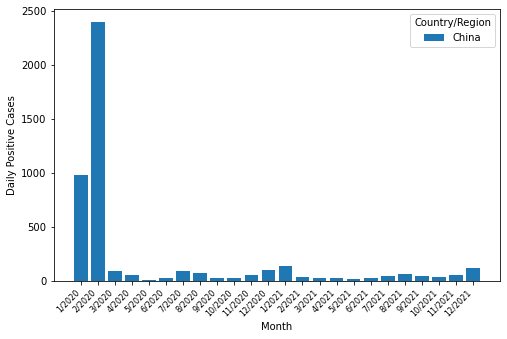

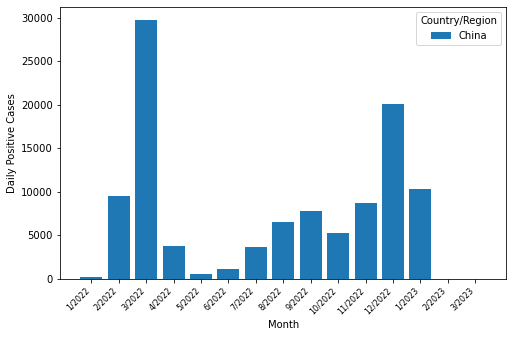

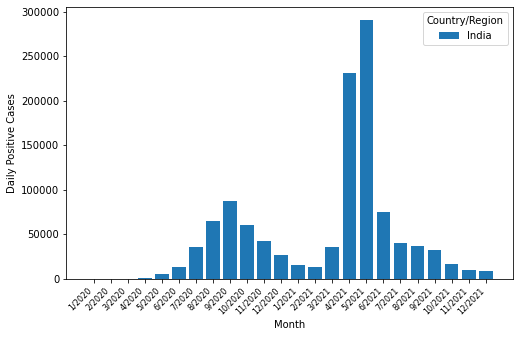

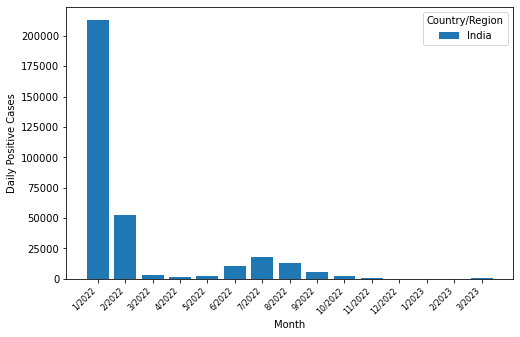

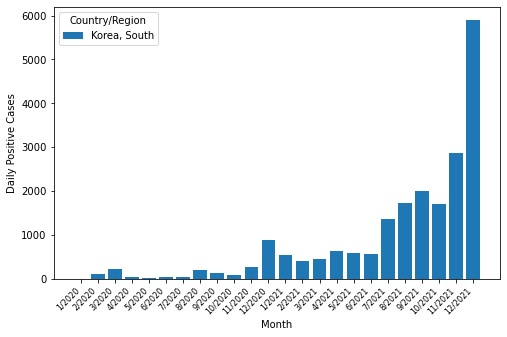

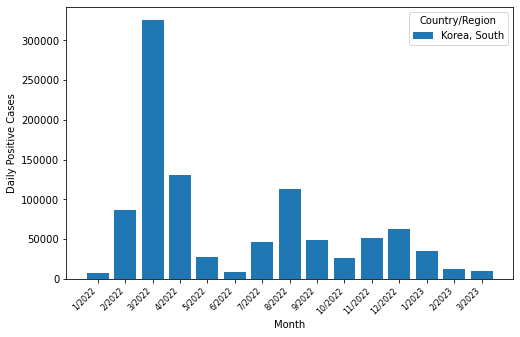

In [42]:
countries = ["China"]
query1_plot(df_query1_plt,countries,2020,2021) 
countries = ["China"]
query1_plot(df_query1_plt,countries,2022,2023) 
countries = ["India"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["India"]
query1_plot(df_query1_plt,countries,2022,2023)
countries = ["Korea, South"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["Korea, South"]
query1_plot(df_query1_plt,countries,2022,2023)

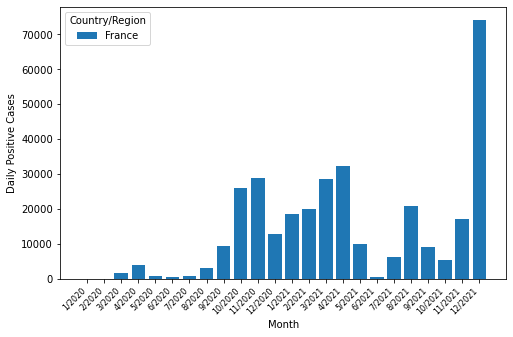

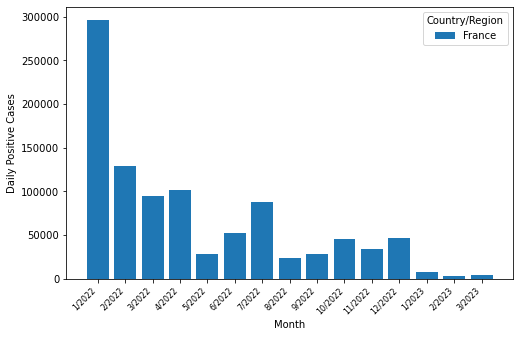

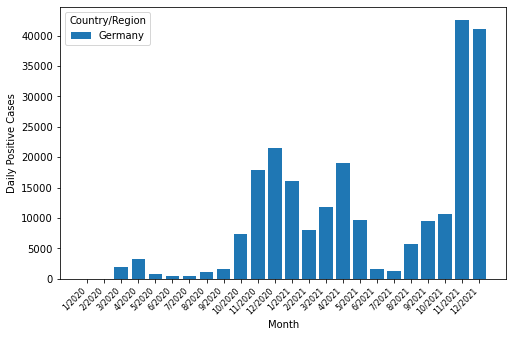

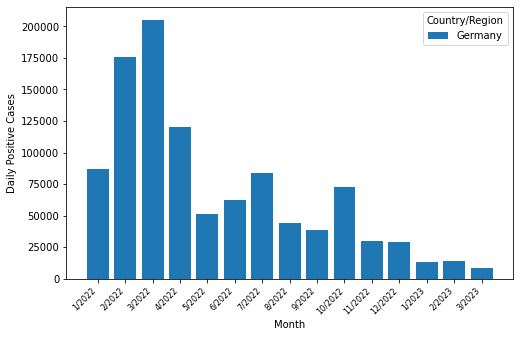

In [43]:
countries = ["France"]
query1_plot(df_query1_plt,countries,2020,2021) 
countries = ["France"]
query1_plot(df_query1_plt,countries,2022,2023) 
countries = ["Germany"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["Germany"]
query1_plot(df_query1_plt,countries,2022,2023)

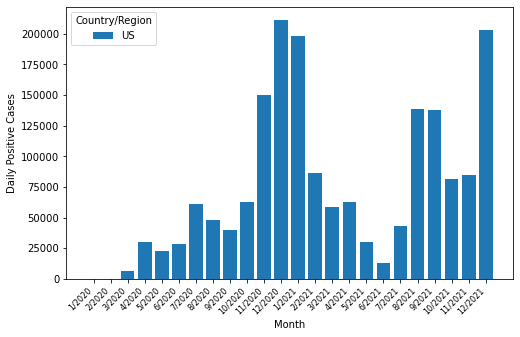

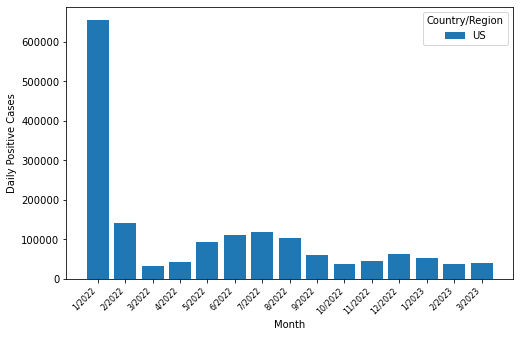

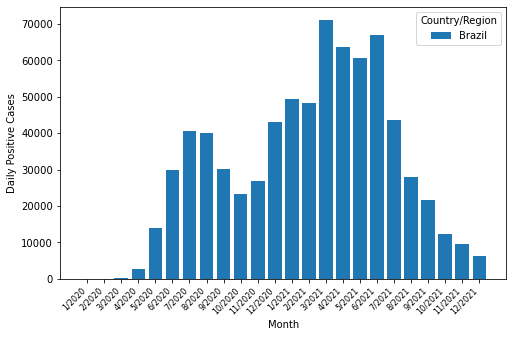

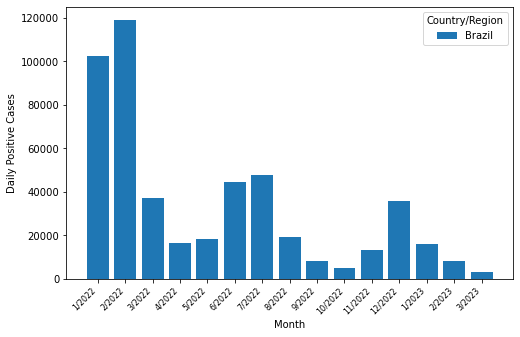

In [44]:
countries = ["US"]
query1_plot(df_query1_plt,countries,2020,2021) 
countries = ["US"]
query1_plot(df_query1_plt,countries,2022,2023) 
countries = ["Brazil"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["Brazil"]
query1_plot(df_query1_plt,countries,2022,2023)

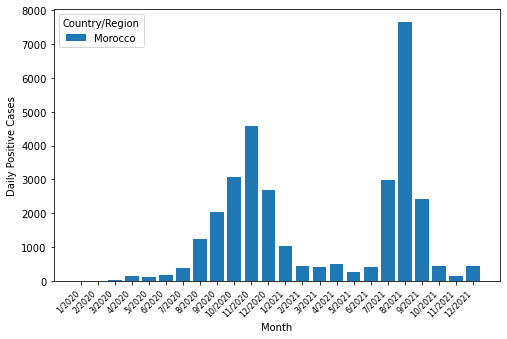

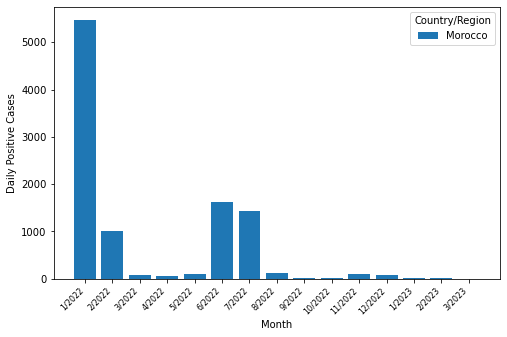

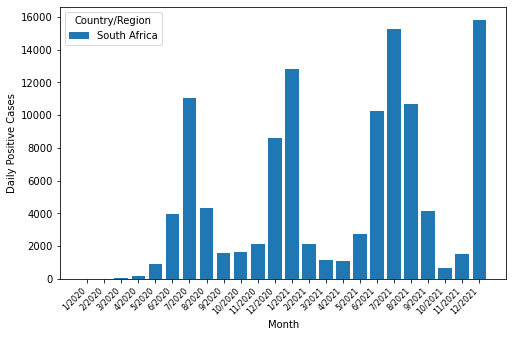

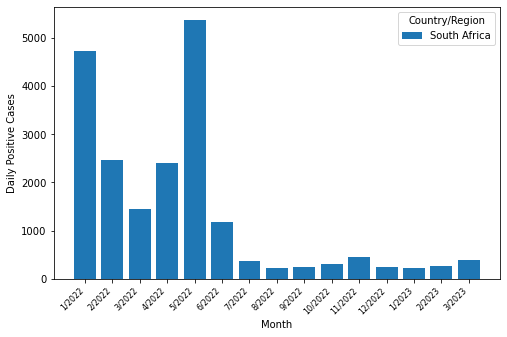

In [45]:
countries = ["Morocco"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["Morocco"]
query1_plot(df_query1_plt,countries,2022,2023)
countries = ["South Africa"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["South Africa"]
query1_plot(df_query1_plt,countries,2022,2023)

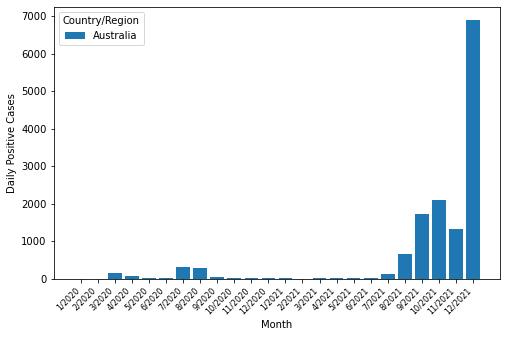

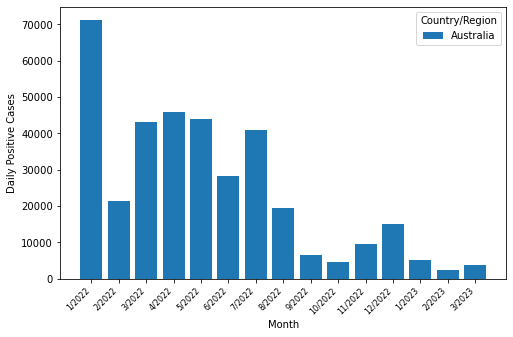

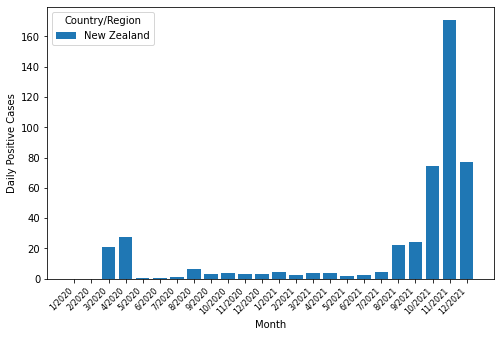

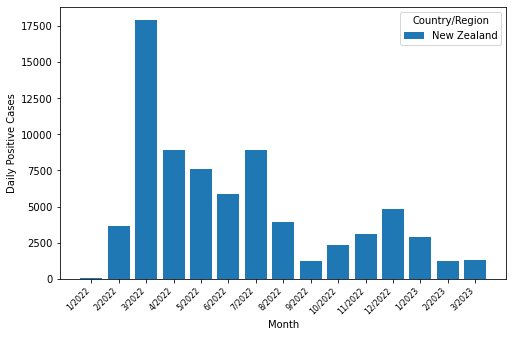

In [46]:
countries = ["Australia"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["Australia"]
query1_plot(df_query1_plt,countries,2022,2023)
countries = ["New Zealand"]
query1_plot(df_query1_plt,countries,2020,2021)
countries = ["New Zealand"]
query1_plot(df_query1_plt,countries,2022,2023)

In [47]:
#Create a line plot representing the trend of daily positive cases by month for specified countries.
def query1_plot2(df_query1_plt,countries):
    
    # Create a line plot
    plt.figure(figsize=(16, 5))

    # Collect distinct months and years
    month_year_df = df_query1_plt.select("Month", "Year").distinct().collect()
    month_year_df = sorted(month_year_df, key=lambda x: (x.Year, x.Month))
    month_year = [f"{row['Month']}/{row['Year']}" for row in month_year_df]

    for country in countries:
        cases_country = df_query1_plt.filter(col("Country/Region") == country)

        # Collect daily cases
        daily_cases_df = cases_country.select("Daily_Positive_Cases").collect()
        daily_cases = [row["Daily_Positive_Cases"] for row in daily_cases_df]
        # Plot the line plot for each country
        plt.plot(month_year, daily_cases, label=country)
    # Add labels, title and legend 
    plt.title('Tendance des Daily_cases par mois')
    plt.xlabel('Month')
    plt.ylabel('Daily_Positive_Cases')
    plt.legend()
    plt.xticks(rotation=45, ha="right", fontsize=8)
    # Displays the plot
    plt.show()


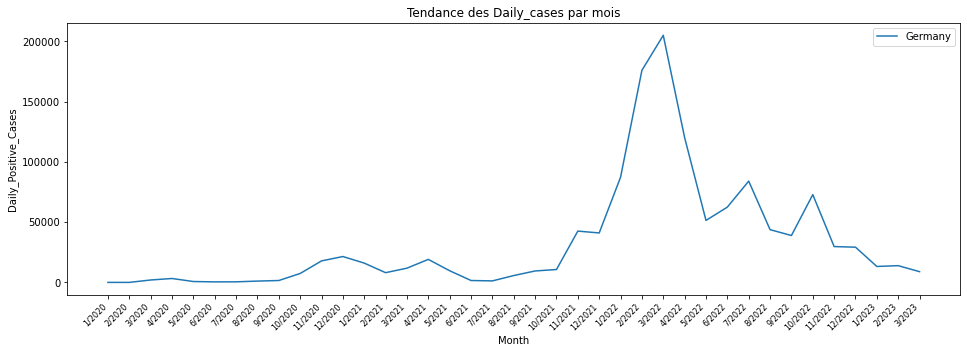

In [48]:
countries = ["Germany"]
query1_plot2(df_query1_plt,countries)

# Query 2

In [49]:
df_final = session_spark.read.option("header", "true").option("inferSchema", "true").csv("dataframe_3_s419255.csv")
df_final.show(10)

+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+--------------+
|Continent|Province/State|Country/Region|     Lat|     Long|Day|Month|Year|Week|Year_Week|Cumulative_Positive_Cases|Positive_Cases|
+---------+--------------+--------------+--------+---------+---+-----+----+----+---------+-------------------------+--------------+
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 22|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 23|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 24|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 25|    1|2020|   4|     2020|                        0|             0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953| 26|    1|2020| 

In [50]:
begin = time.time()

In [51]:
#Calculates the slope of a linear regression  for a given set of y values.
def slope_regression(y):
    model = LinearRegression()
    # Create x values as the number of days
    x = [i for i in range(0,len(y))]
    # Create a linear regression model and fit it to the data
    X = np.array(x).reshape(-1,1)
    Y = np.array(y).reshape(-1,1)
    model.fit(X,Y)
    # Extract the slope from the model
    slope = float(model.coef_[-1,-1])
    return slope
# Create a PySpark UDF
slope_regression_udf = udf(slope_regression, FloatType())

In [52]:
# Ranks states based on the slope of linear regression fitted to their positive cases.
def ranking_states(df):
    window_spec = Window.partitionBy("Province/State","Country/Region")
    # Collect positive cases for each country and state into a list
    df = df.withColumn("Positive_Cases_Country",collect_list("Positive_Cases").over(window_spec))
    # Calculate the slope of the linear regression using the UDF
    df = df.withColumn('Slope', slope_regression_udf(col("Positive_Cases_Country")))
    # Group by Continent, Province/State, Country/Region, Lat, and Long and calculate the average slope
    df = df.groupBy("Continent","Province/State","Country/Region","Lat","Long").agg(avg("Slope").alias("Slope_regression"))
    df = df.drop("Positive_Cases_Country","Slope")                         
    df = df.sort(col("Slope_regression").desc())
    return df

In [53]:
df_query2_top100 = ranking_states(df_final)
df_query2_top100 = df_query2_top100.select("Continent","Province/State","Country/Region","Lat","Long","Slope_regression")
# Creation of the column Rank to categorize countries based on the slope of the linear regression
df_query2_top100 = df_query2_top100.withColumn("Rank", monotonically_increasing_id()+1)
# Dataframe including the top 100 countries or states most impacted by COVID-19 based on the slope of the linear regression.
df_query2_top100 = df_query2_top100.filter(col("Rank") <= 100)
df_query2_top100 = df_query2_top100.drop("Continent")

In [54]:
# Join the original dataFrame with the top 100 states dataFrame based on Province/State and Country/Region
df_query2 = df_final.join(df_query2_top100, ["Province/State","Country/Region"], "inner")
df_query2 = df_query2.orderBy("Rank","Year_Week","Month","Day")
# Calculate the number of positives cases of COVID-19 per day by continent
df_query2 = df_query2.groupBy("Continent","Year_Week","Week","Day").agg(sum("Positive_Cases").alias("Daily_Positive_Cases_Continent"))
# Calculate various statistics for the number of positives cases of COVID-19 per week by continent
df_query2= df_query2.groupBy("Continent","Year_Week","Week").agg(
    round(mean("Daily_Positive_Cases_Continent"),4).alias("Mean_Cases_Week"),
    round(stddev("Daily_Positive_Cases_Continent"),4).alias("Stddev_Cases_Week"),
    min("Daily_Positive_Cases_Continent").alias("Min_Cases_Week"),
    max("Daily_Positive_Cases_Continent").alias("Max_Cases_Week")
)
df_query2 = df_query2.select("Continent","Week","Year_Week","Mean_cases_Week","Stddev_Cases_Week","Min_Cases_Week","Max_Cases_Week").orderBy("Continent","Year_Week",'Week')
# Calculate the processing time for the query
time_query2 = time.time() - begin
print("Query2 - Processing time :",time_query2)

Query2 - Processing time : 0.33785510063171387


In [55]:
df_query2.show(10)

+---------+----+---------+---------------+-----------------+--------------+--------------+
|Continent|Week|Year_Week|Mean_cases_Week|Stddev_Cases_Week|Min_Cases_Week|Max_Cases_Week|
+---------+----+---------+---------------+-----------------+--------------+--------------+
|   Africa|   4|     2020|            0.0|              0.0|             0|             0|
|   Africa|   5|     2020|            0.0|              0.0|             0|             0|
|   Africa|   6|     2020|            0.0|              0.0|             0|             0|
|   Africa|   7|     2020|            0.0|              0.0|             0|             0|
|   Africa|   8|     2020|            0.0|              0.0|             0|             0|
|   Africa|   9|     2020|            0.0|              0.0|             0|             0|
|   Africa|  10|     2020|         0.2857|            0.488|             0|             1|
|   Africa|  11|     2020|         3.2857|           4.4987|             0|            13|

In [56]:
df_query2.toPandas().to_csv("query2_s419255.csv", header = True, index = False)

In [57]:
df_query2_top100.toPandas().to_csv("query2_top100_s419255.csv", header = True, index = False)

# Plot - Query 2

In [58]:
df_query2_top100 = session_spark.read.option("header", "true").option("inferSchema", "true").csv("query2_top100_s419255.csv")
df_query2_top100.show()

+---------------+--------------+---------+----------+------------------+----+
| Province/State|Country/Region|      Lat|      Long|  Slope_regression|Rank|
+---------------+--------------+---------+----------+------------------+----+
|        Unknown|         Japan|36.204824|138.252924| 94.19123077392578|   1|
|        Unknown|  Korea, South|35.907757|127.766922| 72.67960357666016|   2|
|        Unknown|       Germany|51.165691| 10.451526| 65.83472442626953|   3|
|        Unknown|        France|  46.2276|    2.2137|52.144168853759766|   4|
|        Unknown|            US|     40.0|    -100.0| 44.69619369506836|   5|
|        Unknown|         Italy| 41.87194|  12.56738|36.660850524902344|   6|
|        Unknown|       Taiwan*|     23.7|     121.0|30.030702590942383|   7|
|        Unknown|       Vietnam|14.058324|108.277199|18.312957763671875|   8|
|        Unknown|        Russia| 61.52401|105.318756| 16.46443748474121|   9|
|        Unknown|United Kingdom|  55.3781|    -3.436|15.64780616

In [59]:
# Create a map with circular markers for the top 100 states.
def plot_map_100_states(df):
    # Create a folium map
    f = folium.Figure(width=517, height=450)
    m = folium.Map(location=[25,11], zoom_start=1,min_zoom = 1,zoom_control=False,scrollWheelZoom=False, dragging=False).add_to(f)
    # Add circular markers to the map 
    for row in df.collect():
        province_state = row["Province/State"] if row["Province/State"] != "Unknown" else row["Country/Region"]
        folium.CircleMarker(
            location=[row["Lat"], row["Long"]],
            radius=1,   # Adjust the circle size as desired
            fill=True,
        ).add_to(m)

    # Return the HTML representation of the folium map for display in Jupyter
    return HTML(m._repr_html_())

In [60]:
plot_map_100_states(df_query2_top100)

C:\Users\moi\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [61]:
df_query2_plt = session_spark.read.option("header", "true").option("inferSchema", "true").csv("query2_s419255.csv")
df_query2_plt.show()

+---------+----+---------+---------------+-----------------+--------------+--------------+
|Continent|Week|Year_Week|Mean_cases_Week|Stddev_Cases_Week|Min_Cases_Week|Max_Cases_Week|
+---------+----+---------+---------------+-----------------+--------------+--------------+
|   Africa|   4|     2020|            0.0|              0.0|             0|             0|
|   Africa|   5|     2020|            0.0|              0.0|             0|             0|
|   Africa|   6|     2020|            0.0|              0.0|             0|             0|
|   Africa|   7|     2020|            0.0|              0.0|             0|             0|
|   Africa|   8|     2020|            0.0|              0.0|             0|             0|
|   Africa|   9|     2020|            0.0|              0.0|             0|             0|
|   Africa|  10|     2020|         0.2857|            0.488|             0|             1|
|   Africa|  11|     2020|         3.2857|           4.4987|             0|            13|

In [62]:
#Create a histogram to compare statistical data for different continents over time.
def query2_plot(df_query2_plt,stastistic):
    # Create a bar plot
    plt.figure(figsize=(20, 8))   
    df = df_query2_plt
    
    # Collect distinct months and years
    week_year_df = df.select("Week", "Year_Week").distinct().collect()
    week_year_df = sorted(week_year_df, key=lambda x: (x.Year_Week, x.Week))
    week_year = [f"{row['Week']}/{row['Year_Week']}" for row in week_year_df]

    # Set the width of the bars
    bar_width = 0.3  
    # Collect statistical data for each continent
    Stats_Africa_df = df.filter(col("Continent") == "Africa").select(statistic).collect()
    Stats_Africa = [row[statistic] for row in Stats_Africa_df]
    Stats_Europe_df = df.filter(col("Continent") == "Europe").select(statistic).collect()
    Stats_Europe = [row[statistic] for row in Stats_Europe_df]
    Stats_Asia_df = df.filter(col("Continent") == "Asia").select(statistic).collect()
    Stats_Asia = [row[statistic] for row in Stats_Asia_df]
    Stats_America_df = df.filter(col("Continent") == "America").select(statistic).collect()
    Stats_America = [row[statistic] for row in Stats_America_df]
    Stats_Oceania_df = df.filter(col("Continent") == "Oceania").select(statistic).collect()
    Stats_Oceania = [row[statistic] for row in Stats_Oceania_df]       

    # Offset to position the bars side by side
    offset = 0.9
    week_year_numeric = [float(x.replace('/', '.')) for x in week_year]  #
    # Plot data for each continent
    plt.bar([x - offset for x in week_year_numeric], Stats_Africa, label="Africa", width=bar_width)
    plt.bar([x - offset/2 for x in week_year_numeric],Stats_Europe, label="Europe", width=bar_width)
    plt.bar([x + offset/2 for x in week_year_numeric], Stats_Asia, label="Asia", width=bar_width)
    plt.bar([x + offset for x in week_year_numeric], Stats_America, label="America", width=bar_width)
    plt.bar([x + offset for x in week_year_numeric], Stats_Oceania, label="Oceania", width=bar_width)

    # Add labels, title and legend
    plt.title(f"{statistic}")
    plt.xlabel('Weeks')
    plt.ylabel('Cases')
    plt.legend(title='Statistics', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45, ha="right", fontsize=8)
    # Displays the plot
    plt.show()


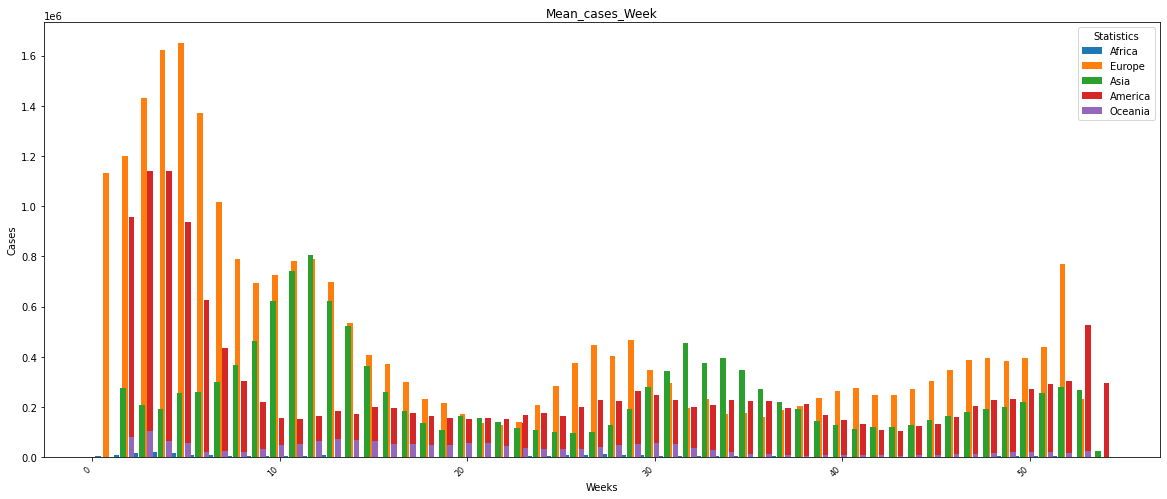

In [63]:
statistic = "Mean_cases_Week"
query2_plot(df_query2_plt,statistic)

In [64]:
# Create a line plot to visualize statistical data for different continents over time.
def query2_plot2(df_query2_plt,statistic):
    #Create a line plot
    plt.figure(figsize=(16, 8))
    df = df_query2_plt
    # Collect distinct months and years
    week_year_df = df.select("Week", "Year_Week").distinct().collect()
    week_year_df = sorted(week_year_df, key=lambda x: (x.Year_Week, x.Week))
    week_year = [f"{row['Week']}/{row['Year_Week']}" for row in week_year_df]

    # Collect statistical data for each continent
    Stats_Africa_df = df.filter(col("Continent") == "Africa").select(statistic).collect()
    Stats_Africa = [row[statistic] for row in Stats_Africa_df]
    Stats_Europe_df = df.filter(col("Continent") == "Europe").select(statistic).collect()
    Stats_Europe = [row[statistic] for row in Stats_Europe_df]
    Stats_Asia_df = df.filter(col("Continent") == "Asia").select(statistic).collect()
    Stats_Asia = [row[statistic] for row in Stats_Asia_df]
    Stats_America_df = df.filter(col("Continent") == "America").select(statistic).collect()
    Stats_America = [row[statistic] for row in Stats_America_df]
    Stats_Oceania_df = df.filter(col("Continent") == "Oceania").select(statistic).collect()
    Stats_Oceania = [row[statistic] for row in Stats_Oceania_df]
    
    # Define x-axis positions and labels
    x_positions = range(0, len(week_year), 5)
    x_labels = [week_year[i] for i in x_positions]
    
    # Plot data for each continent
    plt.plot(week_year, Stats_Africa, label="Africa")
    plt.plot(week_year, Stats_Europe, label="Europe")
    plt.plot(week_year, Stats_Asia, label="Asia")
    plt.plot(week_year, Stats_America, label="America")
    plt.plot(week_year, Stats_Oceania, label="Oceania")
    
    # Add labels, title and legend
    plt.title(f"{statistic}")
    plt.xlabel('Week')
    plt.ylabel('Cases')
    plt.legend()
    plt.xticks(x_positions, x_labels, rotation=45, ha="right", fontsize=8)
    # Displays the plot
    plt.show()

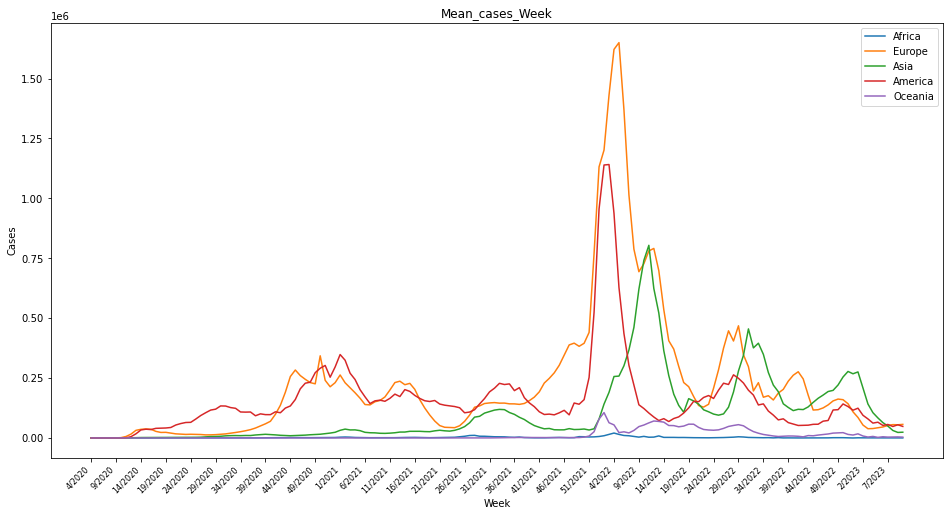

In [65]:
statistic = "Mean_cases_Week"
query2_plot2(df_query2_plt,statistic)

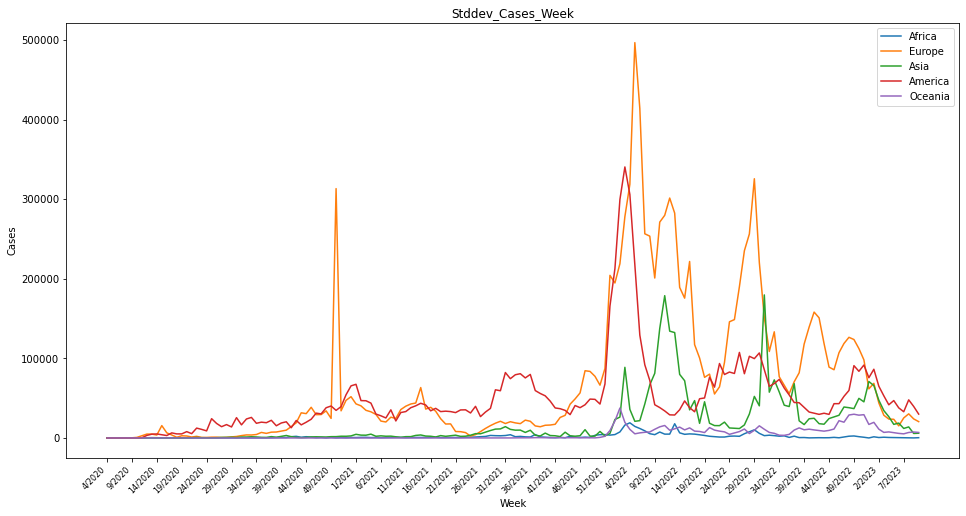

In [66]:
statistic = "Stddev_Cases_Week"
query2_plot2(df_query2_plt,statistic)

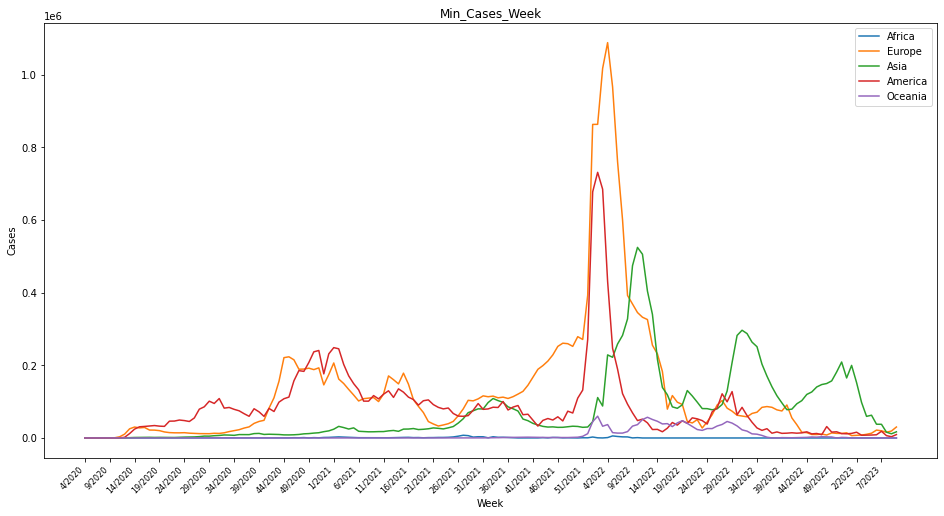

In [67]:
statistic = "Min_Cases_Week"
query2_plot2(df_query2_plt,statistic)

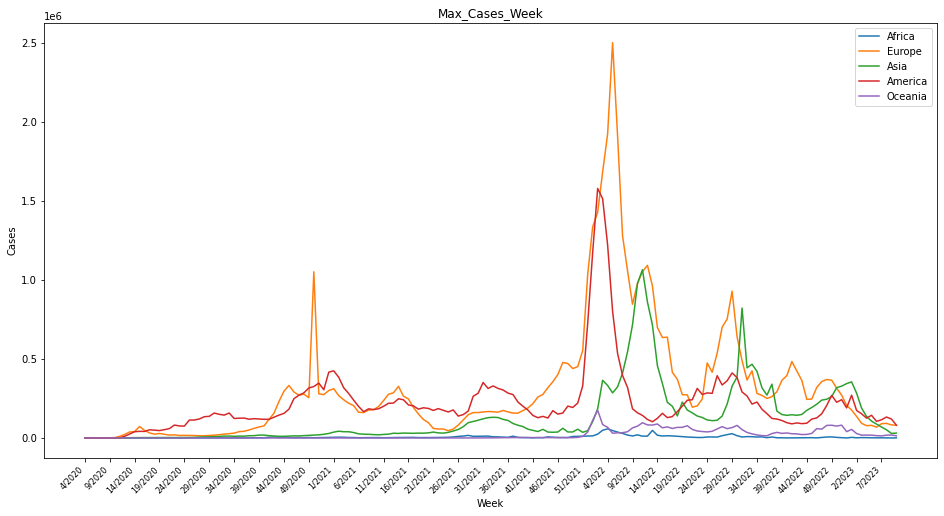

In [68]:
statistic = "Max_Cases_Week"
query2_plot2(df_query2_plt,statistic)

# Query 3

In [69]:
df_final = session_spark.read.option("header", "true").option("inferSchema", "true").csv("dataframe_3_s419255.csv")
df_final = df_final.select("Continent","Province/State","Country/Region","Lat","Long","Month","Year","Positive_Cases","Cumulative_Positive_Cases")
df_final.show()

+---------+--------------+--------------+--------+---------+-----+----+--------------+-------------------------+
|Continent|Province/State|Country/Region|     Lat|     Long|Month|Year|Positive_Cases|Cumulative_Positive_Cases|
+---------+--------------+--------------+--------+---------+-----+----+--------------+-------------------------+
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|    1|2020|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|    1|2020|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|    1|2020|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|    1|2020|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|    1|2020|             0|                        0|
|     Asia|       Unknown|   Afghanistan|33.93911|67.709953|    1|2020|             0|          

In [70]:
begin = time.time()

In [71]:
# Ranks states or provinces based on the average slope of positive cases per month.
def ranking_states_per_month(df):
    # Collect positive cases data for each state or province and calculate the slope
    window_spec = Window.partitionBy("Province/State","Country/Region","Year","Month")
    df = df.withColumn("Positive_Cases_Country",collect_list("Positive_Cases").over(window_spec))
    df = df.withColumn('Slope', slope_regression_udf(col("Positive_Cases_Country")))
    # Group by Province/State, Country/Region, Year and Month and calculate the average slope
    df = df.groupBy("Province/State","Country/Region","Year","Month").agg(round(avg("Slope"),4).alias("Slope_regression"),round(avg("Lat"),4).alias("Lat"),round(avg("Long"),4).alias("Long"))
    df = df.drop("Positive_Cases_country","Slope")                         
    df = df.sort(col("Year"),col("Month"),col("Slope_regression").desc())
    return df

In [72]:
df_query3_top50 = ranking_states_per_month(df_final)
df_query3_top50 = df_query3_top50.select("Province/State","Country/Region","Year","Month","Slope_regression","Lat","Long")
window_spec = Window.partitionBy("Year","Month").orderBy("Year","Month")
# Creation of the column Rank to categorize countries based on the slope of the linear regression
df_query3_top50 = df_query3_top50.withColumn("Rank", row_number().over(window_spec))
# Dataframe including the top 50 countries or states most impacted per month by COVID-19 based on the slope of the linear regression.
df_query3_top50 = df_query3_top50.filter(col("Rank") <= 50)
df_query3_top50 = df_query3_top50.fillna("Unknown", subset=["Province/State"])

In [73]:
df_query3_top50.toPandas().to_csv("query3_top50_s419255.csv", header = True, index = False)

In [74]:
df_query3_top50 = session_spark.read.option("header", "true").option("inferSchema", "true").csv("query3_top50_s419255.csv")

In [75]:
# Applies K-means clustering to the input dataFrame for the top 50 states or provinces based on slope regression.
def k_means(df_query3_top50):
    feature_columns = ["Slope_regression"]
    # Assemble features into a vector column
    assembler_kmeans = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_query3_kmeans = assembler_kmeans.transform(df_query3_top50)

    df_query3_cluster = None
    # Apply K-means clustering for each unique month and year
    for month, year in df_query3_kmeans.select("Month", "Year").distinct().collect():
        df_query3_kmeans_month = df_query3_kmeans.filter((col('Month') == month) & (col('Year') == year))
        # Set up K-means model
        kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_query3_kmeans_month)
        # Transform data
        df_cluster = model.transform(df_query3_kmeans_month)
        df_cluster = df_cluster.drop("features")
        # Union the results for different months and years
        if df_query3_cluster is None:
            df_query3_cluster = df_cluster
        else:
            df_query3_cluster = df_query3_cluster.union(df_cluster)
    df_query3_cluster = df_query3_cluster.orderBy("Year","Month", desc("Slope_regression"))
    return df_query3_cluster

In [76]:
df_query3_cluster = k_means(df_query3_top50)
# Calculate the processing time for the query
time_query3 = time.time() - begin
print("Query3 - Processing time :",time_query3)

Query3 - Processing time : 170.79512548446655


In [77]:
df_query3_cluster.show()

+--------------+--------------+----+-----+----------------+-------+--------+----+----------+
|Province/State|Country/Region|Year|Month|Slope_regression|    Lat|    Long|Rank|prediction|
+--------------+--------------+----+-----+----------------+-------+--------+----+----------+
|         Hubei|         China|2020|    1|        114.3879|30.9756|112.2707|   1|         1|
|      Zhejiang|         China|2020|    1|         13.9394|29.1832|120.0934|   2|         0|
|     Guangdong|         China|2020|    1|          8.1576|23.3417|113.4244|   3|         0|
|         Henan|         China|2020|    1|          8.1212|37.8957|114.9042|   4|         0|
|         Hunan|         China|2020|    1|          7.3212|27.6104|111.7088|   5|         0|
|       Jiangxi|         China|2020|    1|          6.6303| 27.614|115.7221|   6|         0|
|         Anhui|         China|2020|    1|          5.0242|31.8257|117.2264|   7|         3|
|       Jiangsu|         China|2020|    1|          4.1818|32.9711| 11

In [79]:
df_query3_cluster.toPandas().to_csv("query3_s419255.csv", header = True, index = False)

# Plot - Query 3

In [80]:
df_query3_plt = session_spark.read.option("header", "true").option("inferSchema", "true").csv("query3_s419255.csv")
df_query3_plt.show()

+--------------+--------------+----+-----+----------------+-------+--------+----+----------+
|Province/State|Country/Region|Year|Month|Slope_regression|    Lat|    Long|Rank|prediction|
+--------------+--------------+----+-----+----------------+-------+--------+----+----------+
|         Hubei|         China|2020|    1|        114.3879|30.9756|112.2707|   1|         1|
|      Zhejiang|         China|2020|    1|         13.9394|29.1832|120.0934|   2|         0|
|     Guangdong|         China|2020|    1|          8.1576|23.3417|113.4244|   3|         0|
|         Henan|         China|2020|    1|          8.1212|37.8957|114.9042|   4|         0|
|         Hunan|         China|2020|    1|          7.3212|27.6104|111.7088|   5|         0|
|       Jiangxi|         China|2020|    1|          6.6303| 27.614|115.7221|   6|         0|
|         Anhui|         China|2020|    1|          5.0242|31.8257|117.2264|   7|         3|
|       Jiangsu|         China|2020|    1|          4.1818|32.9711| 11

In [81]:
# Displays a table of K-means clusters for a specific month and year, 
# along with the list of countries/provinces/states in each cluster.
def table_kmeans_clusters(df_query3_plt, month, year):
    # Filter the DataFrame for the specified month and year
    df = df_query3_plt.filter((col("Month") == month) & (col("Year") == year))
    df = df.withColumn('Country/Region/Province/State', when(col("Province/State") !="Unknown", col("Province/State")).otherwise(col("Country/Region")))

    # Group by cluster and get a list of countries
    clusters_df = df.groupBy("prediction").agg(collect_list("Country/Region/Province/State").alias("Countries"))

   # Create a schema for a new dataFrame
    schema = StructType([
        StructField("Cluster", IntegerType(), True),
        StructField("Countries", ArrayType(StringType()), True),
    ])

    # Create the DataFrame from the grouping result and the schema
    result = clusters_df.select("prediction", "Countries").withColumnRenamed("prediction", "Cluster").withColumnRenamed("Countries", "CountriesList").orderBy("Cluster")
    # Display the clustering results
    print("The clustering algorithm K-means for:",month,"/",year,"\n")
    result.show()
    # Print the list of countries for each cluster
    for i in range (0,4) :
        cluster = result.filter(col("Cluster") == i).select("CountriesList").collect()
        print("Cluster",i,":")
        for row in cluster:
            print(row[0])

In [82]:
table_kmeans_clusters(df_query3_plt,2,2023)

The clustering algorithm K-means for: 2 / 2023 

+-------+--------------------+
|Cluster|       CountriesList|
+-------+--------------------+
|      0|[South Africa, Sw...|
|      1|           [Germany]|
|      2|[Russia, Austria,...|
|      3|[France, Romania,...|
+-------+--------------------+

Cluster 0 :
['South Africa', 'Switzerland', 'Chile', 'Belgium', 'Singapore', 'Kazakhstan', 'Moldova', 'Slovenia', 'Serbia', 'Israel', 'Trinidad and Tobago', 'India', 'Slovakia', 'Paraguay', 'Montenegro', 'Kuwait', 'Australian Capital Territory', 'New Brunswick', 'Tasmania', 'Iran', 'Estonia', 'Qatar', 'Cameroon', 'Bulgaria', 'Tunisia', 'Honduras', 'United Arab Emirates', 'Pakistan', 'Malta', 'Nigeria', 'Armenia', 'Saudi Arabia', 'Panama', 'Kosovo', 'Manitoba', 'Angola', 'Mali', 'Lithuania', 'Iceland', 'Prince Edward Island']
Cluster 1 :
['Germany']
Cluster 2 :
['Russia', 'Austria', 'Poland']
Cluster 3 :
['France', 'Romania', 'New Zealand', 'Czechia', 'Bahrain', 'Netherlands']


In [83]:
# Displays a folium map with circular markers for each country/province/state, 
# colored based on K-means cluster, for a specific month and year
def plot_map_kmeans_clusters(df_query3_plt,month,year):
    # Filter the DataFrame for the specified month and year
    df = df_query3_plt.filter((col("Month") == month) & (col("Year") == year))
    # Create a folium map
    f = folium.Figure(width=517, height=450)
    m = folium.Map(location=[25,11], zoom_start=1,min_zoom = 1,zoom_control=False,scrollWheelZoom=False, dragging=False).add_to(f)

    # Define different colors for each cluster
    cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'} 

    # Add circular markers to the map with custom colors
    for row in df.collect():
        province_state = row["Province/State"] if row["Province/State"] != "Unknown" else row["Country/Region"]
        folium.CircleMarker(
            location=[row["Lat"], row["Long"]],
            radius=1,  
            popup=f"{province_state}, Cluster {row['prediction']}",
            color=cluster_colors[row['prediction']],
            fill=True,
            fill_color=cluster_colors[row['prediction']],
        ).add_to(m)

    # Display the map in Jupyter
    return HTML(m._repr_html_())

In [84]:
plot_map_kmeans_clusters(df_query3_plt,1,2020)

# Processing Times

In [85]:
# Plots the processing time for different tasks
def plot_processing_time(processing_times, tasks):
    # Set the width of the bars
    bar_width = 0.3 
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(tasks, processing_times, width=bar_width)
    
    # Add labels and title
    plt.xlabel('Task')
    plt.ylabel('Processing Time (seconds)')
    plt.title('Processing Time for Different Tasks')

    # Display the chart in Jupyter
    plt.show()

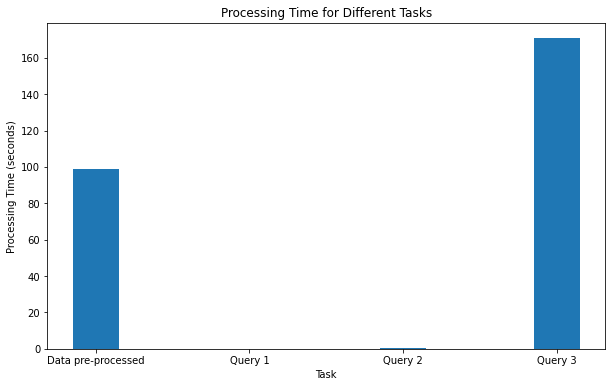

In [86]:
Processing_time = [time_preprocessed, time_query1, time_query2, time_query3]
Task = ["Data pre-processed", "Query 1", "Query 2", "Query 3"]
plot_processing_time(Processing_time, Task)

# Stop the Spark Session

In [106]:
session_spark.stop()